In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import vectorbt as vbt
import plotly.graph_objects as go

In [185]:
money = 100000
start = '2018-01-01'
end = '2018-12-31'
stop_loss = 0.05
fast_window = 30
slow_window = 90

### Загружаю почасовые данные 

In [148]:
data = pd.read_csv('SBER_H1.csv')
new_columns = {
    'datetime' : 'Datetime',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close'
}
data = data.rename(columns=new_columns).set_index('Datetime').drop(columns=['volume'])
data = data[start:end]
data

,Open,High,Low,Close
Datetime,,,,
2018-01-03 10:00:00,226.88,230.00,226.35,228.52
2018-01-03 11:00:00,228.45,230.58,228.41,229.66
2018-01-03 12:00:00,229.65,230.00,229.00,229.90
2018-01-03 13:00:00,229.90,230.80,229.60,230.38
2018-01-03 14:00:00,230.42,231.87,230.39,231.27
...,...,...,...,...
2018-12-29 14:00:00,186.07,186.08,185.78,185.88
2018-12-29 15:00:00,185.88,185.95,185.70,185.70
2018-12-29 16:00:00,185.70,186.15,185.70,186.15


### Расчет скользящих средних

In [149]:
fast_ma = vbt.MA.run(data['Open'], fast_window, short_name='fast')
slow_ma = vbt.MA.run(data['Open'], slow_window, short_name='slow')
sig_buy = fast_ma.ma_crossed_above(slow_ma)
sig_sale = fast_ma.ma_crossed_below(slow_ma)
sig_sale_true = sig_sale[sig_sale == True].index

### Отчёт по сделкам и прибыли

In [187]:
pf = vbt.Portfolio.from_signals(data['Close'], sig_buy, sig_sale, init_cash = money, sl_stop = stop_loss)
orders_report = pf.orders.records_readable
print(orders_report)
total_profit = pf.total_profit()
print('Прибыль:',total_profit)

    Order Id  Column            Timestamp        Size   Price  Fees  Side
0          0       0  2018-02-15 10:00:00  377.102346  265.18   0.0   Buy
1          1       0  2018-03-05 18:00:00  377.102346  277.00   0.0  Sell
2          2       0  2018-03-06 11:00:00  375.219475  278.39   0.0   Buy
3          3       0  2018-03-07 10:00:00  375.219475  275.64   0.0  Sell
4          4       0  2018-03-23 18:00:00  394.753802  262.00   0.0   Buy
5          5       0  2018-03-28 11:00:00  394.753802  252.93   0.0  Sell
6          6       0  2018-04-06 16:00:00  383.356034  260.45   0.0   Buy
7          7       0  2018-04-09 10:00:00  383.356034  244.57   0.0  Sell
8          8       0  2018-04-20 17:00:00  437.873087  214.12   0.0   Buy
9          9       0  2018-05-18 10:00:00  437.873087  225.80   0.0  Sell
10        10       0  2018-06-05 11:00:00  449.621387  219.90   0.0   Buy
11        11       0  2018-06-05 14:00:00  449.621387  216.51   0.0  Sell
12        12       0  2018-06-25 11:00

### Поиск стоп-лоссов

In [188]:
sell = orders_report[orders_report['Side']=='Sell']['Timestamp']
sell_stop_loss = sell[~sell.isin(sig_sale_true)].unique()
sell_stop_loss_price = orders_report.loc[orders_report['Timestamp'].isin(sell_stop_loss),'Price']
print('Стоп-лоссы:',sell_stop_loss)

Стоп-лоссы: ['2018-04-09 10:00:00' '2018-08-23 12:00:00' '2018-10-19 17:00:00'
 '2018-12-06 12:00:00']


### Графики

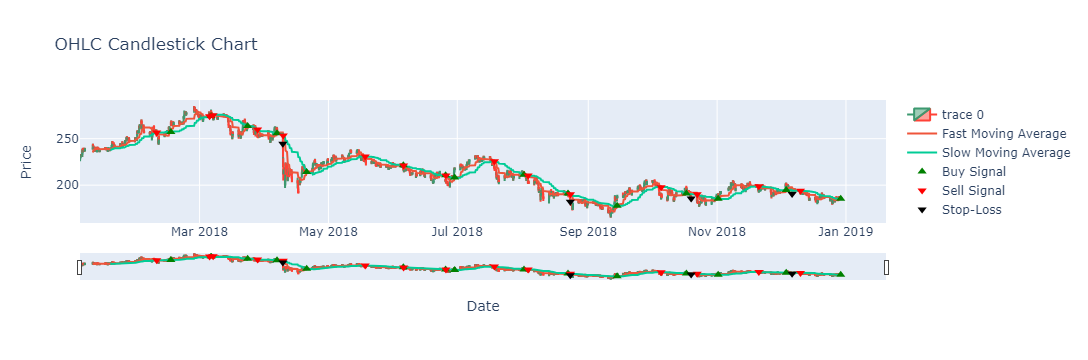

In [152]:
fig = go.Figure(data=[go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'])])
fig.add_trace(go.Scatter(x=data.index, y=fast_ma.ma, mode='lines', name='Fast Moving Average'))
fig.add_trace(go.Scatter(x=data.index, y=slow_ma.ma, mode='lines', name='Slow Moving Average'))
fig.add_trace(go.Scatter(x=data.index[sig_buy], y=fast_ma.ma[sig_buy], mode='markers', 
                         marker=dict(symbol='triangle-up', color='green', size=8), name='Buy Signal'))
fig.add_trace(go.Scatter(x=data.index[sig_sale], y=fast_ma.ma[sig_sale], mode='markers', 
                         marker=dict(symbol='triangle-down', color='red', size=8), name='Sell Signal'))
fig.add_trace(go.Scatter(x=sell_stop_loss, y=sell_stop_loss_price, mode='markers', 
                         marker=dict(symbol='triangle-down', color='black', size=8), name='Stop-Loss'))
fig.update_layout(title='OHLC Candlestick Chart',
                   xaxis_title='Date',
                   yaxis_title='Price')
fig.show()

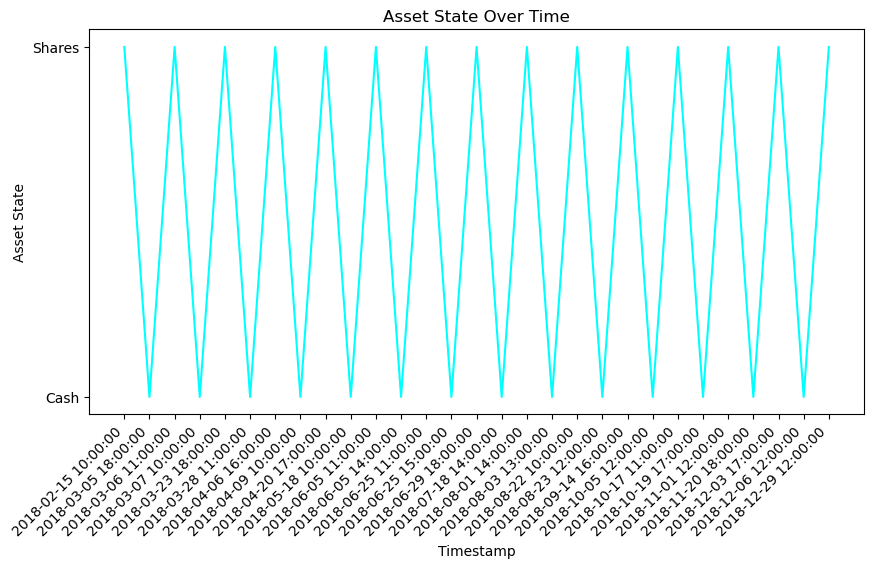

In [153]:
timestamps = orders_report['Timestamp']
positions = [1 if side == 'Buy' else 0 for side in orders_report['Side']]
plt.figure(figsize=(10, 5))
plt.plot(timestamps, positions, color='cyan', linestyle='-')
plt.title('Asset State Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Asset State')
plt.yticks([0, 1], ['Cash', 'Shares'])
plt.xticks(rotation=45, ha='right') 
plt.show()

### Поиск оптимльного размера скользящих,максимизирующий прибыль от покупок/продаж

C:\Users\User\anaconda3\Lib\site-packages\jupyter_client\session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



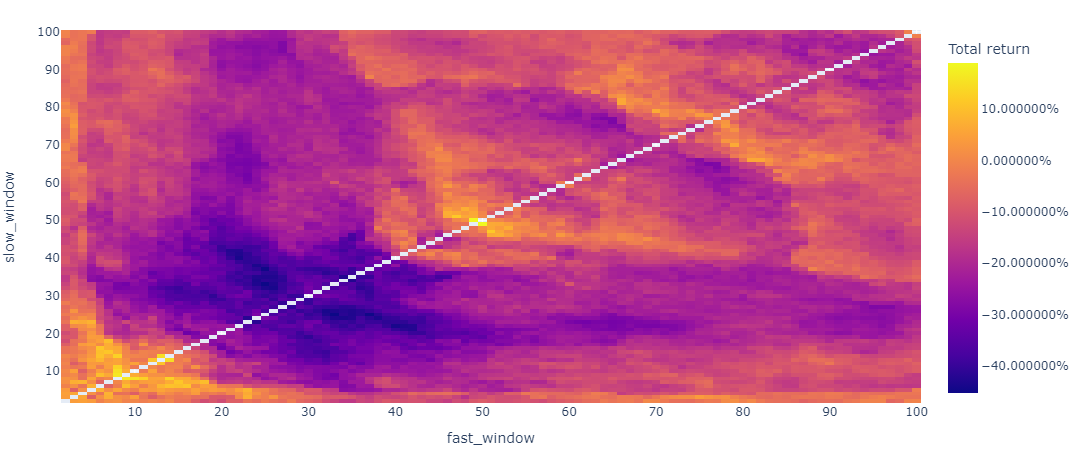

оптимальный размер fast window,slow_window: (49, 50) 
максимальная прибыль: 19061.279984352164


In [190]:
windows = np.arange(2, 101)
fast_ma, slow_ma = vbt.MA.run_combs(data['Open'], window=windows, r=2, short_names=['fast', 'slow'])
entries = fast_ma.ma_above(slow_ma)
exits = fast_ma.ma_below(slow_ma)

portfolio_kwargs = dict(size=np.inf, freq='1D')
portfolio = vbt.Portfolio.from_signals(data['Close'], init_cash = money, entries=entries, exits=exits, **portfolio_kwargs)

fig = portfolio.total_return().vbt.heatmap(
    x_level='fast_window', 
    y_level='slow_window', 
    symmetric=True,
    trace_kwargs=dict(colorbar=dict(title='Total return', tickformat='%'))
)

fig.show()

print('оптимальный размер fast window,slow_window:',portfolio.total_profit().idxmax(),'\nмаксимальная прибыль:',portfolio.total_profit().max())